In [292]:
suppressPackageStartupMessages({
    library(VariantAnnotation)
    library(tidyverse)
})

In [293]:
read_vcf <- function(path) {
    readVcf(path, param=ScanVcfParam(info=c("S", "DOM", "PO", "GO", "MT"), geno="GT"))
}

In [294]:
get_allele_counts <- function(vcf, mut_type) {
    mut_pos <- info(vcf)$MT == mut_type
    gr <- granges(vcf)[mut_pos]

    gt_mat <- geno(vcf)$GT[mut_pos, ]
    allele_counts <- apply(gt_mat, 2, function(gt) { str_count(gt, "1") })
    info_cols <- as.data.frame(info(vcf)[mut_pos, c("S", "DOM", "PO", "GO")])

    mcols(gr) <- bind_cols(info_cols, as.data.frame(allele_counts))
    names(gr) <- NULL

    # shift VCF coordinates back to the SLiM 0-based system
    gr <- shift(gr, shift=-1)

    sort(gr)
}

In [295]:
read_regions <- function(region) {
    regions_bed <- paste0("../data/slim_coords/", region, "_regions.bed")
    gr <- read_tsv(regions_bed, col_types="ciicdiii") %>%
        makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE)
    gr
}

In [296]:
read_sites <- function(region) {
    sites_bed <- paste0("../data/slim_coords/", region, "_all_sites.bed")
    gr <- read_tsv(sites_bed, col_types="ciiii") %>%
        select(real_chrom=chrom, real_start=start, real_end=end, start=slim_start, end=slim_end) %>%
        mutate(chrom=1) %>% 
        makeGRangesFromDataFrame(keep.extra.columns=TRUE)
    gr
}

In [297]:
transpose_sites <- function(slim_sites, real_sites) {
    hits <- findOverlaps(slim_sites, real_sites)
    transposed <- as.data.frame(mcols(real_sites)) %>%
        setNames(c("chrom", "start", "end")) %>%
        makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>%
        .[queryHits(hits)]
    mcols(transposed) <- mcols(slim_sites)

    transposed
}

In [298]:
nea_per_ind <- function(gr) {
    ind_counts <- as.data.frame(mcols(gr)) %>%
         select(starts_with("i")) %>%
         summarise_all(sum) %>%
         t %>%
         as.vector
    
    ind_counts / length(gr) / 2
}

In [299]:
vcf_path <- "../data/simulations/promoter_h_0.5_rep_1_gen_1.vcf.gz"
region <- "promoter"

In [220]:
gap_vs_func_nea <- function(vcf_path, region) {
    vcf <- read_vcf(vcf_path)
    slim_sites <- get_allele_counts(vcf, mut_type=1)
    real_sites <- read_sites("promoter")
    
    markers <- transpose_sites(slim_sites, real_sites)

    regions <- read_regions(region)
    
    region_markers <- subsetByOverlaps(markers, regions)
    gap_markers <- subsetByOverlaps(markers, regions, invert=TRUE)
    
    bind_rows(
        tibble(region="gap", nea=nea_per_ind(gap_markers)),
        tibble(region=region, nea=nea_per_ind(region_markers))
    )          
}

In [233]:
nea_h <- lapply(c("0.0", "0.5", "1.0"), function(h) {
    gap_vs_func_nea(paste0("../data/simulations/promoter_h_", h, "_rep_1_gen_2200.vcf.gz"), "promoter") %>% mutate(h=h)
}) %>% bind_rows

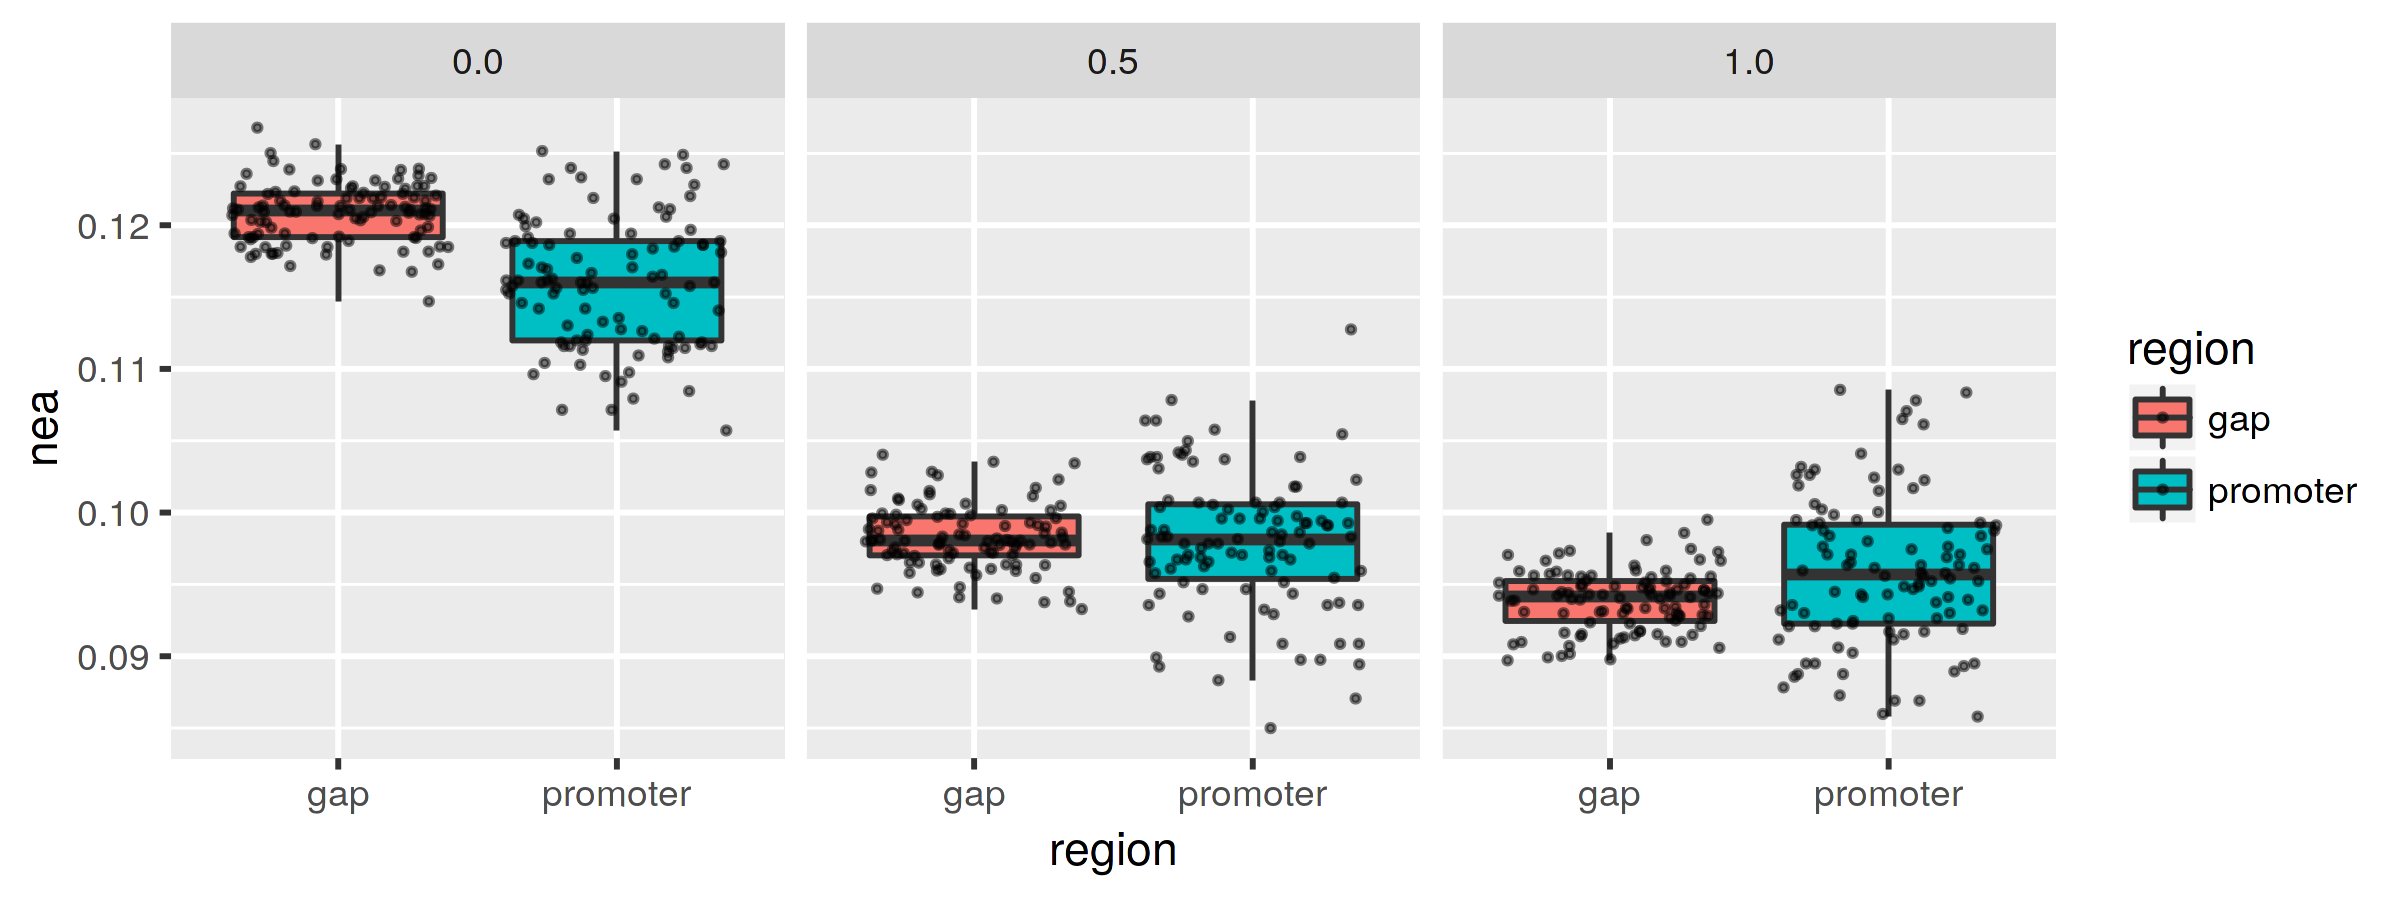

In [257]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

ggplot(nea_h, aes(region, nea, fill=region)) + geom_boxplot(outlier.shape=NA) + geom_jitter(alpha=1/2, size=0.5) + facet_grid(. ~ h)

In [290]:
df_h <- lapply(c("promoter", "protein_coding", "tf_binding_site"), function(r) {
lapply(c("0.0", "0.5", "1.0"), function(h) {
    files <- list.files(path="../data/simulations/", pattern=paste0(r, "_h_", h, "_rep_.*trajectory.*"), full.names=TRUE)
    lapply(files, function(f) {
        suppressMessages(read_tsv(f) %>% mutate(rep=f, h=h, reg=r))
    }) %>% bind_rows
}) %>%
    bind_rows %>% 
    group_by(h, gen, reg) %>% summarise(nea_mean=mean(mean), nea_sd=mean(sd)) %>%
    ungroup
}) %>% bind_rows

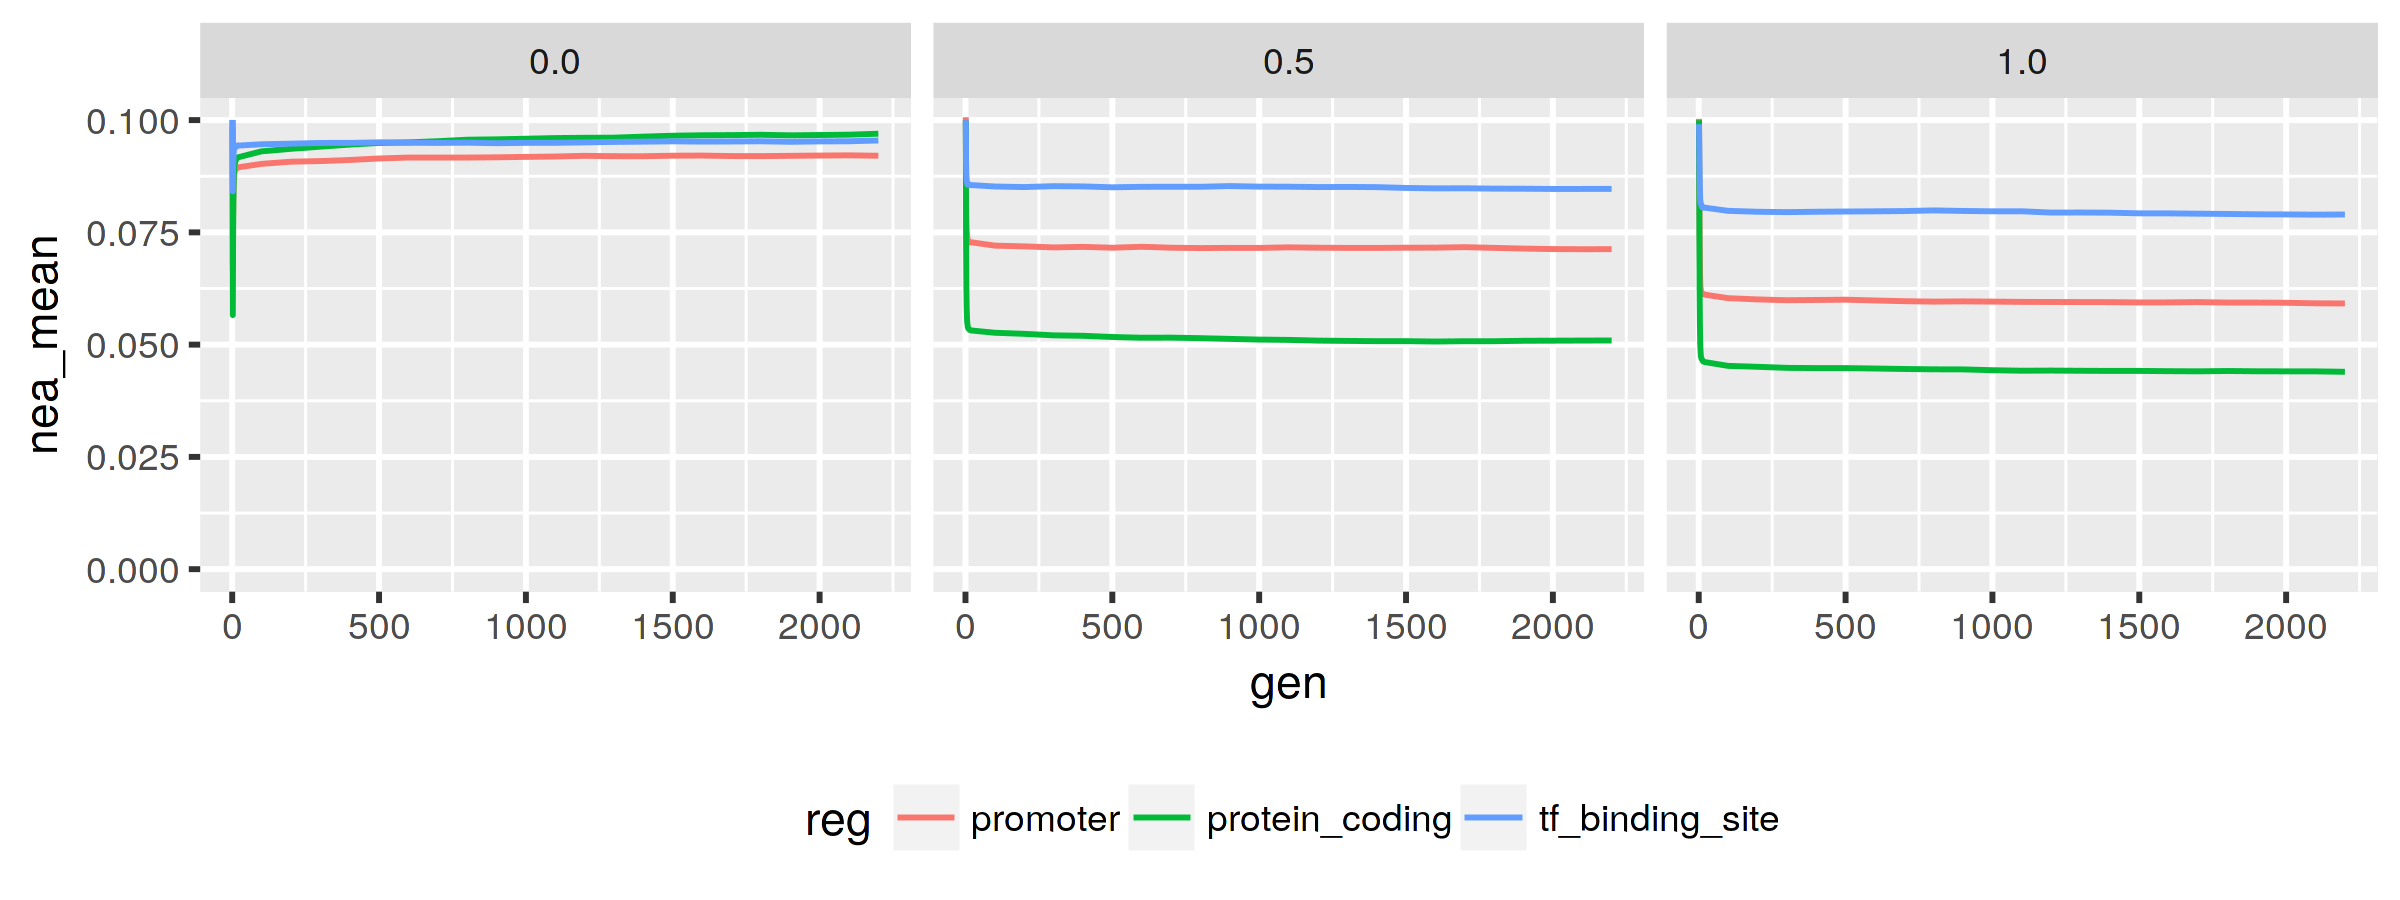

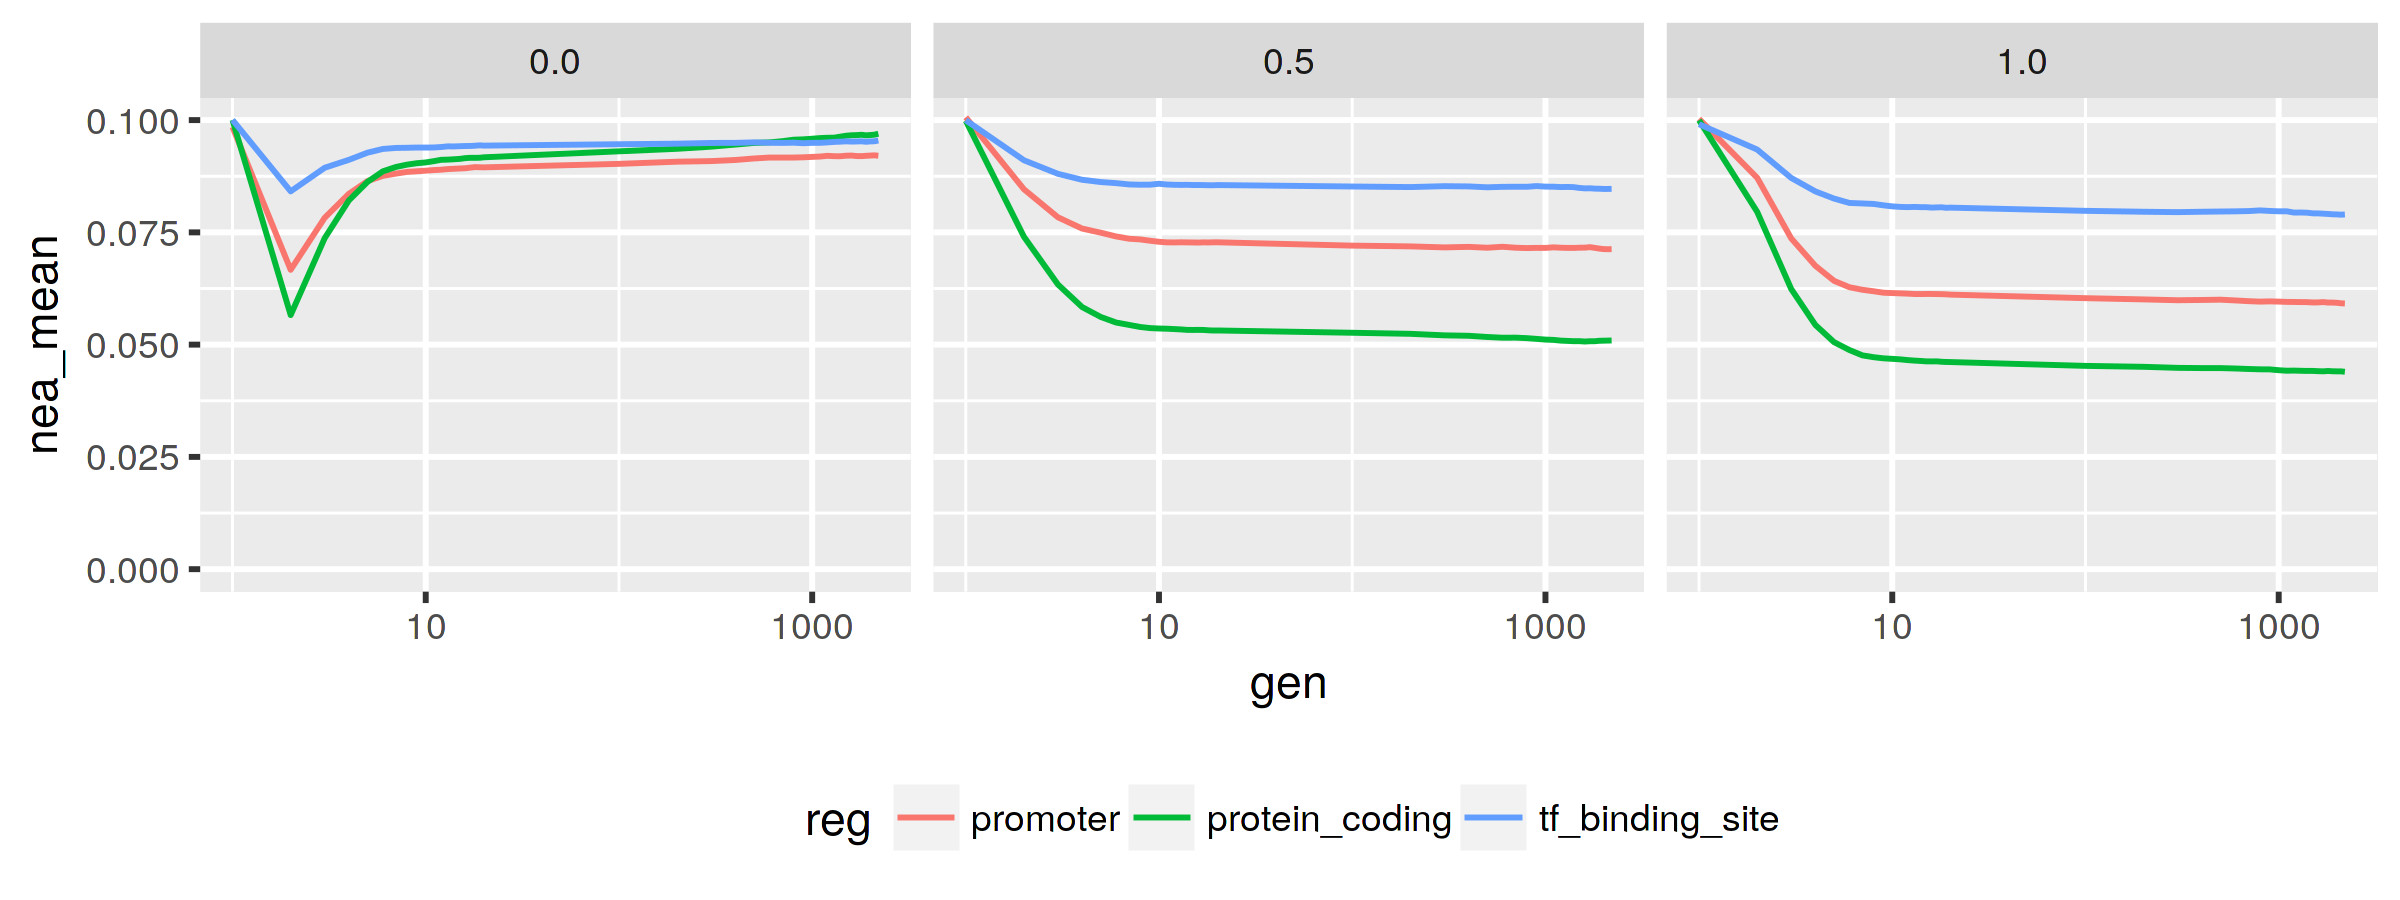

In [291]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

ggplot(df_h, aes(gen, nea_mean)) + geom_line(aes(color=reg)) + facet_grid(. ~ h) + coord_cartesian(y=c(0, 0.1)) + theme(legend.position="bottom")
ggplot(df_h, aes(gen, nea_mean)) + geom_line(aes(color=reg)) + facet_grid(. ~ h) + coord_cartesian(y=c(0, 0.1)) + theme(legend.position="bottom") + scale_x_log10()

In [326]:
x <- function(vcf_path) {
    vcf <- read_vcf(vcf_path)
    
    region_markers <- get_allele_counts(vcf, mut_type=1)
    gap_markers <- get_allele_counts(vcf, mut_type=2)
    
    bind_rows(
        tibble(region="gap", nea=nea_per_ind(gap_markers)),
        tibble(region="exon", nea=nea_per_ind(region_markers))
    )          
}

In [332]:
a <- lapply(c("0.0", "0.5", "1.0"), function(h) {
    x(paste0("../data/simulations/old_", h, ".vcf")) %>% mutate(h=h)
}) %>% bind_rows

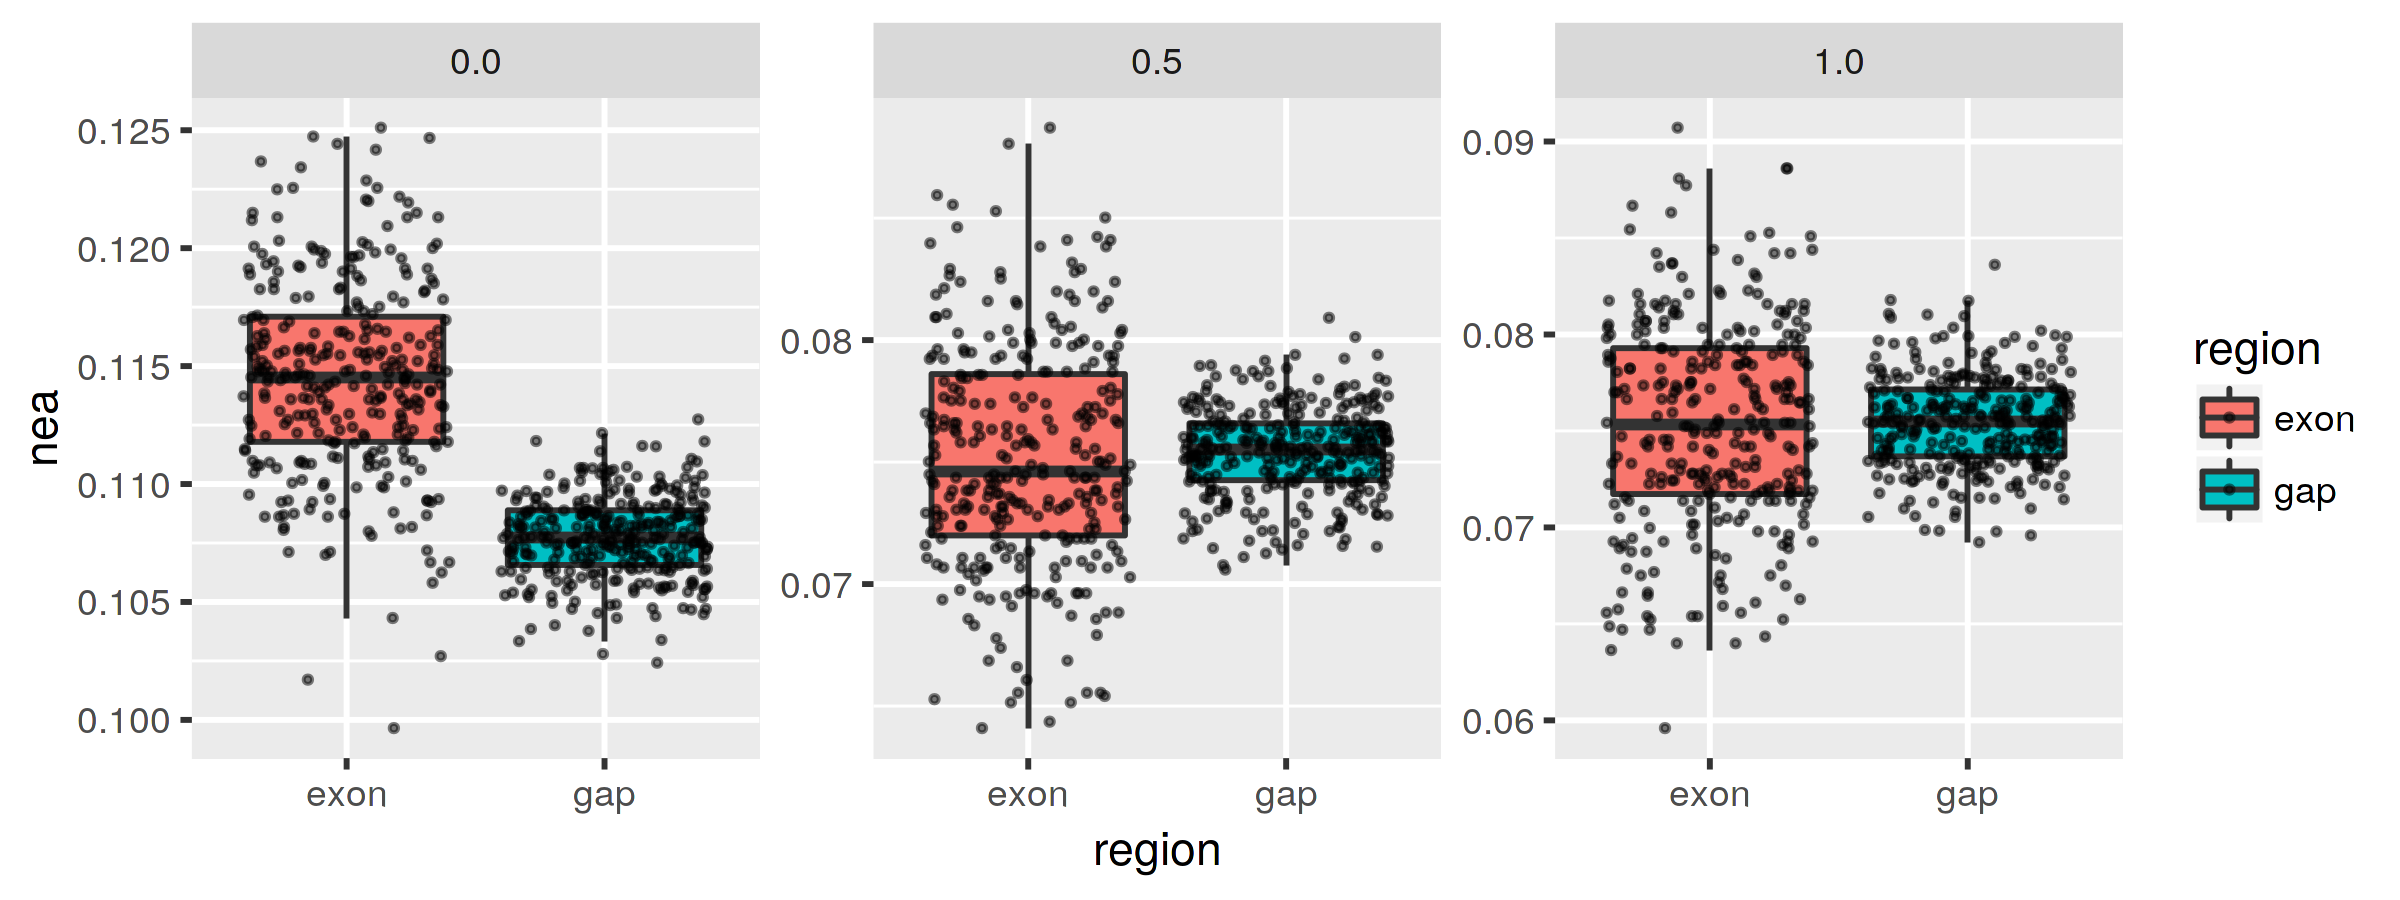

In [337]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

ggplot(a, aes(region, nea, fill=region)) + geom_boxplot(outlier.shape=NA) + geom_jitter(alpha=1/2, size=0.5) +
    facet_wrap(~ h, scales="free_y")

In [223]:
for (f in list.files("../data/simulations", "promoter_h_0.5_rep_1_gen_*.*vcf", full.names=TRUE)) {
    vcf <- read_vcf(f)
    marker_counts <- get_allele_counts(vcf, mut_type=1)
    cat(f, "\t", mean(nea_per_ind(marker_counts)), "\n")
}

../data/simulations/promoter_h_0.5_rep_1_gen_1.vcf.gz 	 0.09 
../data/simulations/promoter_h_0.5_rep_1_gen_10.vcf.gz 	 0.06809177 
../data/simulations/promoter_h_0.5_rep_1_gen_100.vcf.gz 	 0.066536 
../data/simulations/promoter_h_0.5_rep_1_gen_1500.vcf.gz 	 0.08449581 
../data/simulations/promoter_h_0.5_rep_1_gen_2200.vcf.gz 	 0.09826743 
../data/simulations/promoter_h_0.5_rep_1_gen_5.vcf.gz 	 0.05865214 
../data/simulations/promoter_h_0.5_rep_1_gen_500.vcf.gz 	 0.06753049 


In [224]:
for (f in list.files("../data/simulations", "promoter_h_0.0_rep_1_gen_*.*vcf", full.names=TRUE)) {
    vcf <- read_vcf(f)
    marker_counts <- get_allele_counts(vcf, mut_type=1)
    cat(f, "\t", mean(nea_per_ind(marker_counts)), "\n")
}

../data/simulations/promoter_h_0.0_rep_1_gen_1.vcf.gz 	 0.06 
../data/simulations/promoter_h_0.0_rep_1_gen_10.vcf.gz 	 0.09561368 
../data/simulations/promoter_h_0.0_rep_1_gen_100.vcf.gz 	 0.09832856 
../data/simulations/promoter_h_0.0_rep_1_gen_1500.vcf.gz 	 0.1084344 
../data/simulations/promoter_h_0.0_rep_1_gen_2200.vcf.gz 	 0.1204241 
../data/simulations/promoter_h_0.0_rep_1_gen_5.vcf.gz 	 0.1001793 
../data/simulations/promoter_h_0.0_rep_1_gen_500.vcf.gz 	 0.09818418 


In [179]:
regions <- read_regions("promoter")

In [180]:
sites <- read_sites("promoter")

In [187]:
transpose_sites(markers, sites)

GRanges object with 55168 ranges and 104 metadata columns:
          seqnames               ranges strand |         S       DOM        PO
             <Rle>            <IRanges>  <Rle> | <numeric> <numeric> <integer>
      [1]     chr1   [1119546, 1119546]      * |         0       0.5         2
      [2]     chr1   [1696390, 1696390]      * |         0       0.5         2
      [3]     chr1   [1707669, 1707669]      * |         0       0.5         2
      [4]     chr1   [1710633, 1710633]      * |         0       0.5         2
      [5]     chr1   [1749357, 1749357]      * |         0       0.5         2
      ...      ...                  ...    ... .       ...       ...       ...
  [55164]    chr22 [50666507, 50666507]      * |         0       0.5         2
  [55165]    chr22 [50677479, 50677479]      * |         0       0.5         2
  [55166]    chr22 [50683395, 50683395]      * |         0       0.5         2
  [55167]    chr22 [50683418, 50683418]      * |         0       0.5    

In [45]:
region_markers <- subsetByOverlaps(markers, regions)
gap_markers <- subsetByOverlaps(markers, regions, invert=TRUE)

In [53]:
nea_per_ind(region_markers)
nea_per_ind(gap_markers)

[1] TRUE

In [62]:
calc_trajectories <- function(prefix, fn) {
    for (f in Sys.glob(paste0(prefix, "*.vcf"))) {
        vcf <- read_vcf(f)
        marker_counts <- get_allele_counts(vcf, type=1)
    }
}

In [63]:
calc_trajectories("../data/simulations/promoter_h_0.5_rep_1_gen_")

../data/simulations/promoter_h_0.5_rep_1_gen_100.vcf ../data/simulations/promoter_h_0.5_rep_1_gen_10.vcf ../data/simulations/promoter_h_0.5_rep_1_gen_1.vcf ../data/simulations/promoter_h_0.5_rep_1_gen_500.vcf ../data/simulations/promoter_h_0.5_rep_1_gen_5.vcf